In [2]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt

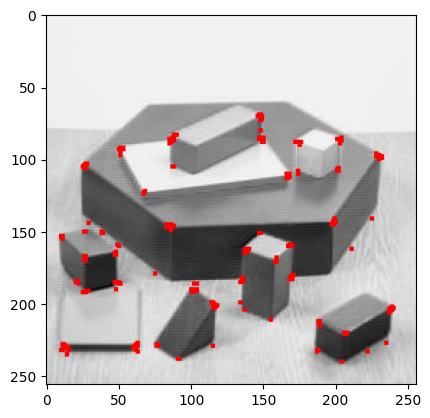

In [2]:
# Harris Corners
img = cv2.imread('images/blox.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)
dst = cv2.cornerHarris(gray,2,3,0.04)

#result is dilated for marking the corners, not important
dst = cv2.dilate(dst,None, iterations=1)

# Threshold for an optimal value, it may vary depending on the image.
img[dst>0.01*dst.max()]=[0,0,255]
plt.imshow(img[...,::-1])

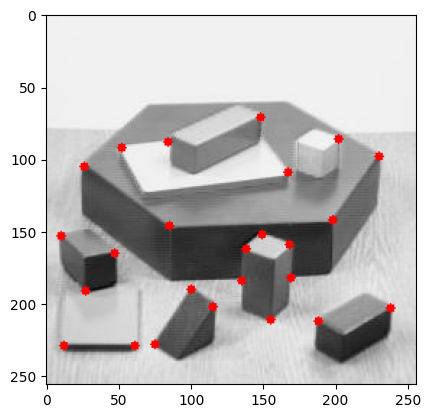

(<matplotlib.image.AxesImage at 0x16f210c4fd0>, None)

In [4]:
# Shi-Tomashi

img = cv2.imread('images/blox.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
corners = cv2.goodFeaturesToTrack(gray,25,0.01,10)
corners = np.intp(corners)

for i in corners:
    x,y = i.ravel()
    cv2.circle(img,(x,y),3,255,-1)

plt.imshow(img),plt.show()

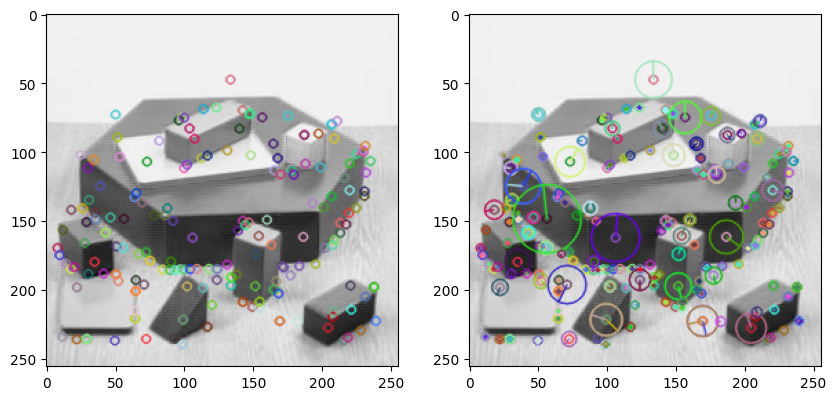

In [11]:
# SIFT : scale invariance
img = cv2.imread('images/blox.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# Initiate SIFT detector
sift = cv2.SIFT_create()
kp = sift.detect(gray,None)

img=cv2.drawKeypoints(img,kp,img)
#plt.imshow(img),plt.show()

r = cv2.drawKeypoints(img, kp, None, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
#plt.imshow(r)

plt.figure(figsize=[10,5])
plt.subplot(121),plt.imshow(img)
plt.subplot(122),plt.imshow(r)
plt.show()

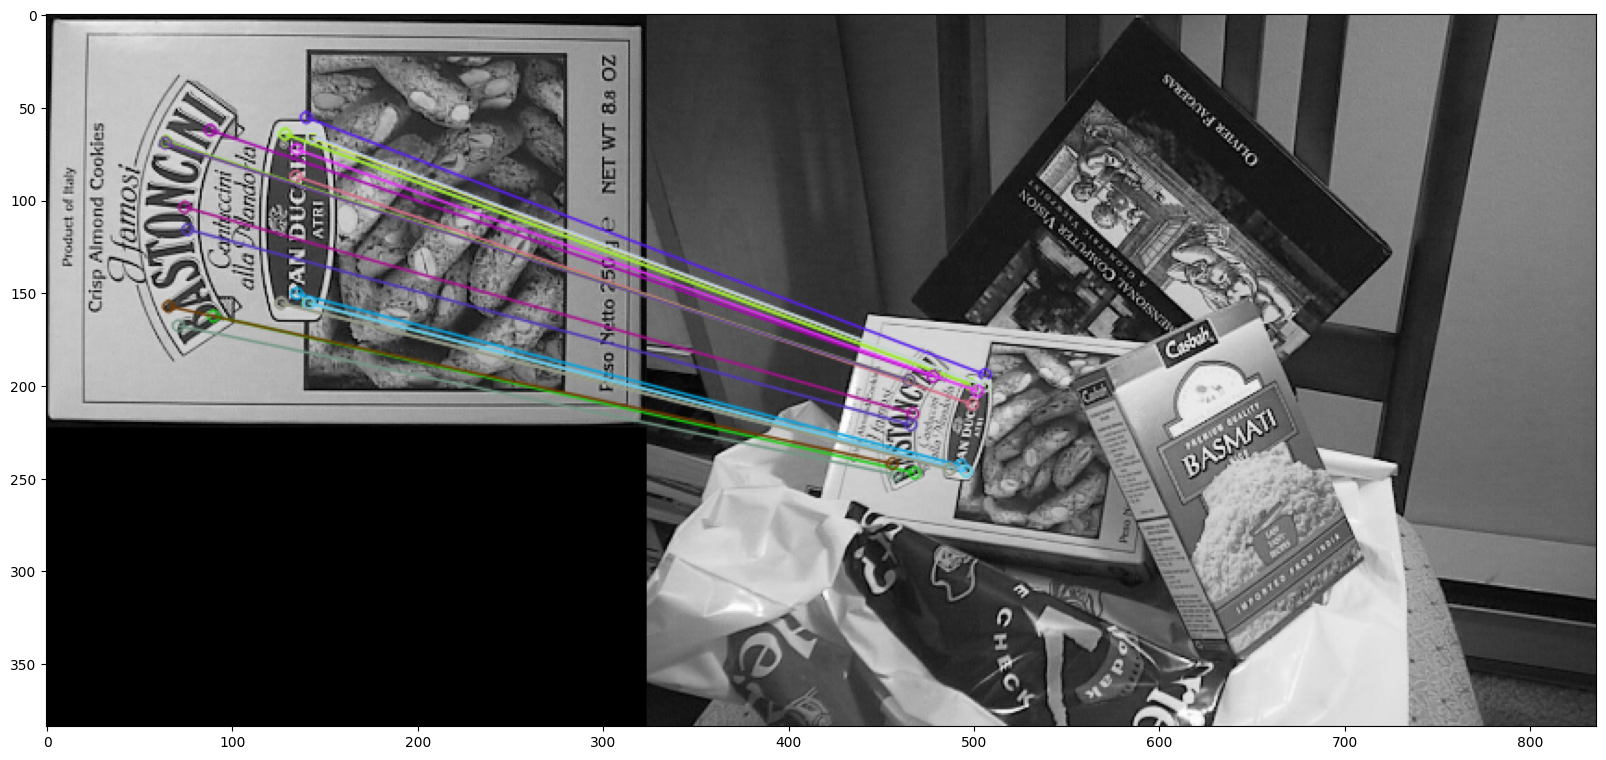


Number of Matching Keypoints Between The Training and Query Images:  453


In [4]:
# ORB 
img1 = cv2.imread('images/box.png')
img2 = cv2.imread('images/box_in_scene.png') 

# Initiate ORB detector
orb = cv2.ORB_create()

# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = False)

# Match descriptors
matches = bf.match(des1, des2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw first 10 matches.
img_result = cv2.drawMatches(img1,kp1,img2,kp2,matches[:20],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=[20,10])
plt.imshow(img_result[...,::-1]),plt.show()
print("\nNumber of Matching Keypoints Between The Training and Query Images: ", len(matches))

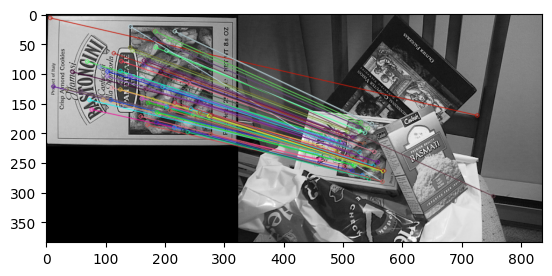

(<matplotlib.image.AxesImage at 0x16f3514c7d0>, None)

In [17]:
# Feature Matching

img1 = cv2.imread('images/box.png', 0)          # queryImage
img2 = cv2.imread('images/box_in_scene.png', 0) # trainImage

# Initiate SIFT detector
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# BFMatcher with default params
bf = cv2.BFMatcher()

matches = bf.knnMatch(des1,des2,k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
        
# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3),plt.show()

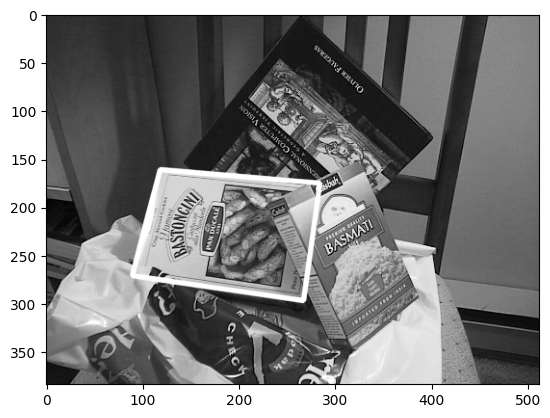

In [20]:
# Finding Objects

img1 = cv2.imread('images/box.png', 0) #query
img2 = cv2.imread('images/box_in_scene.png', 0) #train

# Initiate SIFT detector
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

MIN_MATCH_COUNT = 10

if len(good)>MIN_MATCH_COUNT:
    
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()

    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

    dst = cv2.perspectiveTransform(pts,M)
    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

plt.imshow(img2, 'gray')